In [16]:
import numpy as np
from dt import *
import pydot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [17]:
class Node:
    decision_val = None
    feature = None
    bucket = None
    left_child = None
    right_child = None
    def __init__(self):
        pass
    

In [70]:
def print_tree(root,parent_id,graph):

    if root is None:
        return

    print_tree(root.left_child,str(2*int(parent_id)+1),graph)
    node = None
    if(root.decision_val != None):
        node = pydot.Node(str(parent_id),label=f"x[{root.feature}]<"+str(root.decision_val)+"\n"+str(root.bucket))
    else:
        node = pydot.Node(str(parent_id),label=str(root.bucket))

    graph.add_node(node)
    print_tree(root.right_child,str(2*int(parent_id)+2),graph)
    
    if(root.left_child or root.right_child is not None):
        graph.add_edge(pydot.Edge(str(parent_id),str(2*int(parent_id)+1),label="<"))
        graph.add_edge(pydot.Edge(str(parent_id),str(2*int(parent_id)+2),label=">="))
    return

def predict(root, train_set):
    
    def test(root, data):
        if root.decision_val is None:
            return np.argmax(np.array(root.bucket))
        
        feature_num = root.feature
        
        if(data[feature_num] < root.decision_val):
            return test(root.left_child, data)
        else:
            return test(root.right_child, data)

    predictions = []
    for datum in train_set:
        predictions.append(test(root,datum))
    return np.array(predictions) 

def bucketizer(labels,num_classes):
    index, count = np.unique(labels, return_counts=True)
    bucket = np.zeros(num_classes).astype(int)
    bucket[index] = count
    return bucket

def ID3(data, labels, num_classes,strategy):

    if(entropy(bucketizer(labels, num_classes)) == 0.0):
        node = Node()
        node.bucket = bucketizer(labels,num_classes)
        return node
        
    decision_func = np.argmax
    if(strategy == "avg_gini_index"):
        decision_func = np.argmin
    
    #here picking the parent node and the test value
    all_features_dec_values = []
    all_features_dec_split_index = []
    for i in range(data.shape[1]):
        attribute = calculate_split_values(
            data, labels,num_classes, i, strategy)
        decision_split_index = decision_func(attribute[:, 1],axis=0)
        decision_value = attribute[:, 0][decision_split_index]

        all_features_dec_values.append(decision_value)
        all_features_dec_split_index.append(attribute[:, 1][decision_split_index])

    feature_num = decision_func(all_features_dec_split_index,axis=0)  # which attribute ginis
    test_val = all_features_dec_values[feature_num]  # test value

    node = Node()
    node.bucket = bucketizer(labels, num_classes)
    node.decision_val = test_val
    node.feature = feature_num

    data_left = data[data[:,feature_num] < test_val]
    data_right = data[data[:,feature_num] >= test_val]
    labels_left = labels[data[:,feature_num] < test_val]
    labels_right = labels[data[:,feature_num] >= test_val]

    if(len(labels_left) == 0):
        node = Node()        
        node.bucket = bucketizer(labels_left, num_classes)

        return node
    if(len(labels_right) == 0):
        node = Node()
        node.bucket = bucketizer(labels_right,num_classes)
        return node

    node.left_child = ID3(data_left,labels_left,num_classes,strategy)
    node.right_child = ID3(data_right,labels_right,num_classes,strategy)

    return node

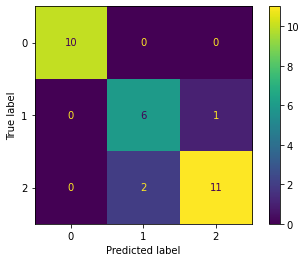

In [71]:
train_set = np.load("dt/train_set.npy ")
train_labels = np.load("dt/train_labels.npy ")
test_set = np.load("dt/test_set.npy ")
test_labels = np.load("dt/test_labels.npy ")

num_classes = len(np.unique(train_labels))
strategy = "avg_gini_index"
prune = False

tree = ID3(train_set,train_labels,num_classes=num_classes,strategy=strategy)

graph = pydot.Dot(graph_type='digraph')
print_tree(tree,0,graph)
graph.write_png("aaaaaaaaaa.png")#strategy+"-"+str(prune)+
predictions = predict(tree, test_set)
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [51]:
tree.right_child.left_child.left_child.left_child.decision_val

4.9